<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment10/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch for best accuracy**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Preprocessing Data
<hr>

In [18]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(30),
        transforms.Normalize((0.1307,),(0.3081,))                    # 이미지를 텐서로 변형합니다.
])

transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,),(0.3081,))            
])

In [19]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform_test)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform_train)

type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  7
255


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


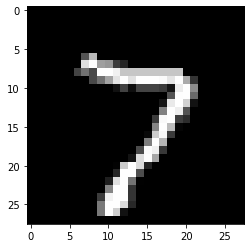

In [20]:
one_image, label = data_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
print(np.max(data_train.train_data[0].view(-1).numpy()))

In [21]:
learning_rate = 0.0015
training_epochs = 100
batch_size = 16
drop_prob = 0.3

In [22]:
train_loader = DataLoader(dataset = data_train, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader = DataLoader(dataset = data_test, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 test loader 생성

# 3. Define Model
<hr>

In [23]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.BatchNorm1d(20*20),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.BatchNorm1d(10*10),
            nn.ReLU(inplace=True),
            nn.Dropout(p=drop_prob)
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=10),
        ) 

        for m in self.modules():
          if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight.data) # Kaming He Initialization
            m.bias.data.fill_(0)                # 편차를 0으로 초기화 

    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out



In [24]:
model = classification().to(device)

In [25]:
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.1, last_epoch=-1)

# 4. Training
<hr>

In [26]:
total_batch= len(train_loader)

In [27]:
print(total_batch)

625


In [28]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [29]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0
    model.train()
    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()

      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    model.eval()
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [30]:
L_train, A_train, L_test, A_test = training(model, criterion, optimizer, training_epochs, train_loader, test_loader)

Epoch: 01 Training Loss: 0.765769303 Testing Loss: 0.305391163  Training Acc: 0.751100004 Testing Acc: 0.908533335
Epoch: 02 Training Loss: 0.498973429 Testing Loss: 0.232037842  Training Acc: 0.842099965 Testing Acc: 0.931733370
Epoch: 03 Training Loss: 0.423137158 Testing Loss: 0.219279394  Training Acc: 0.863199949 Testing Acc: 0.935550034
Epoch: 04 Training Loss: 0.395658314 Testing Loss: 0.192951053  Training Acc: 0.878299952 Testing Acc: 0.942733347
Epoch: 05 Training Loss: 0.354303151 Testing Loss: 0.169818237  Training Acc: 0.886399984 Testing Acc: 0.949649990
Epoch: 06 Training Loss: 0.340031236 Testing Loss: 0.159025237  Training Acc: 0.890799999 Testing Acc: 0.953900039
Epoch: 07 Training Loss: 0.318857908 Testing Loss: 0.153280720  Training Acc: 0.901600003 Testing Acc: 0.955733359
Epoch: 08 Training Loss: 0.301838309 Testing Loss: 0.145747691  Training Acc: 0.904100001 Testing Acc: 0.957750022
Epoch: 09 Training Loss: 0.294721484 Testing Loss: 0.147003934  Training Acc: 0.

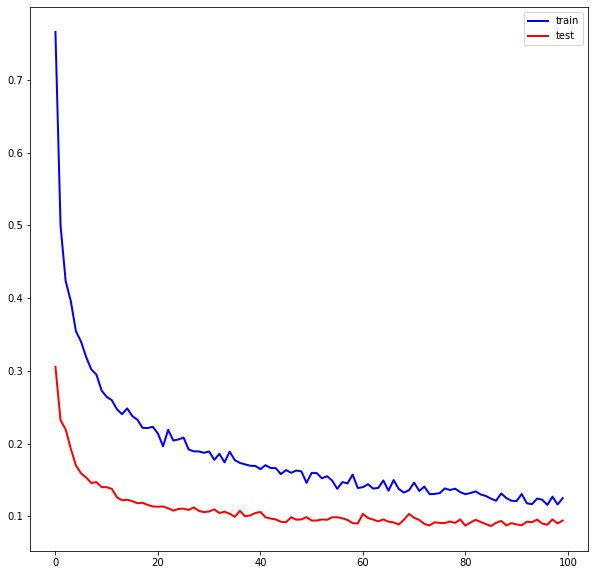

In [31]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

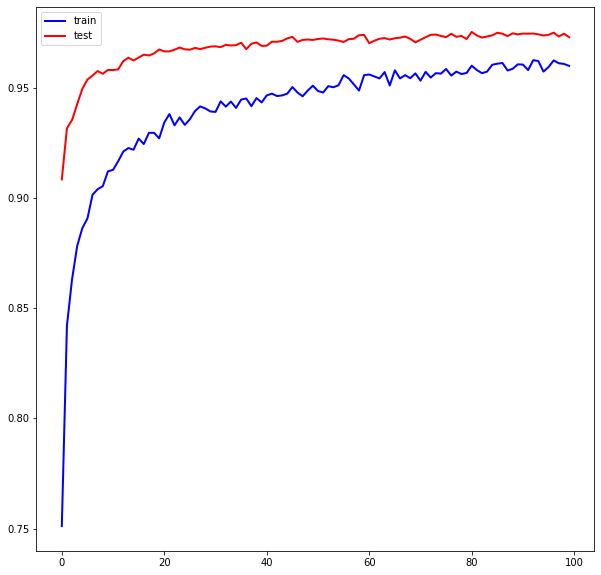

In [32]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [34]:
print("training loss    %.2f" %(L_train[-1]))
print("testing loss     %.2f" %(L_test[-1]))
print("training acc    %.2f" %(A_train[-1]))
print("testing acc     %.2f" %(A_test[-1]))

training loss    0.12
testing loss     0.09
training acc    0.96
testing acc     0.97


# 5. Output
<hr>

## 1. Plot the training and testing losses with a batch size of 32

## 2. Plot the training and testing accuracies with a batch size of 32

## 3. Plot the training and testing losses with a batch size of 64

## 4. Plot the training and testing accuracies with a batch size of 64

## 5. Plot the training and testing losses with a batch size of 128

## 6. Plot the training and testing accuracies with a batch size of 128

## 7. Print the loss at convergence with different mini-batch sizes

## 8. Print the accuracy at convergence with different mini-batch sizes